Finding Dominant Color Names from Color Space Coordinates and Images
=========================================

![](jupysmug.png)

### Let's install some software.

This notebook will explore various techniques for analyzing the contents of digital images
and computing:

1.  Color names from RGB color space coordinates.

2.  Finding a color "nearest" a preset pallette of colors.

3.  Computing an image's dominant color and returning a "nearest" color name.

The methods tested here were collected from many 
sources, ["Lesser artists borrow, great artists steal."](https://www.brainyquote.com/quotes/igor_stravinsky_137813)
One of these days I will have to blog about the difference between ***programming***, *thinking for yourself*,
and ***gargling***, *looking up code snippets on the web.* 

Testing disparate code snippets always turns into a configuration exercise.
The following install commands gather required packages that I didn't find in the Anaconda distribution.

In [ ]:
!cd \anaconda3
!python -m pip install webcolors

In [ ]:
!cd \anaconda3
!python -m pip install Pillow

### Notebook Imports

In [1]:
import webcolors
import numpy as np
import struct
from PIL import Image
from matplotlib import pyplot as plt
import scipy
import scipy.misc
import scipy.cluster
from collections import namedtuple
from math import sqrt
import random
from sklearn.cluster import KMeans

### Using `webcolors` to Reverse Color Code.

After installing `webcolors` test it with this code snippet from [Stack Overflow](https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python).

In [2]:
# modified to return distance from actual color
def closest_color(requested_color):
    min_colors = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return (min_colors[min(min_colors.keys())], sqrt(min(min_colors.keys()))) 

def get_color_name(requested_color):
    try:
        rgb_distance = 0
        closest_name = actual_name = webcolors.rgb_to_name(requested_color)
    except ValueError:
        closest_name , rgb_distance = closest_color(requested_color)
        actual_name = None
    return (actual_name, closest_name, rgb_distance)

requested_color = (119, 172, 152)
actual_name, closest_name , rgb_distance = get_color_name(requested_color)

print("Actual color name:", actual_name, ", closest color name:", closest_name, " rgb distance:", rgb_distance)

Actual color name: None , closest color name: cadetblue  rgb distance: 28.91366458960192


In [3]:
rgb0 = (0,0,0)
rgb1 = (255,255,255)
rgb2 = (255,0,0)
rgb3 = (0,255,0)
rgb4 = (0,0,255)

print(get_color_name(rgb0))
print(get_color_name(rgb1))
print(get_color_name(rgb2))
print(get_color_name(rgb3))
print(get_color_name(rgb4))

('black', 'black', 0)
('white', 'white', 0)
('red', 'red', 0)
('lime', 'lime', 0)
('blue', 'blue', 0)


### Generate Some Random Colors

In [4]:
print(random.randint(0, 255))

114


In [5]:
for a,b in 15 * [(0,255)]:
    rgb = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    print(get_color_name(rgb)[1:])

('steelblue', 44.24929377967517)
('lightseagreen', 29.8496231131986)
('yellowgreen', 23.83275057562597)
('mediumpurple', 14.352700094407323)
('royalblue', 49.3254498205541)
('red', 40.620192023179804)
('darkturquoise', 32.49615361854384)
('greenyellow', 45.27692569068709)
('greenyellow', 34.72751070837067)
('mediumspringgreen', 58.557663887829406)
('royalblue', 61.0163912403872)
('darkmagenta', 45.58508528016593)
('aquamarine', 26.30589287593181)
('yellow', 33.76388603226827)
('seagreen', 28.6705423736629)


### Loading Test Images

The following images, selected from the 
directories [generated by](https://github.com/bakerjd99/smugpyter/blob/master/notebooks/smugpyter.py) `SmugPyter`,
will be used to test various dominant color calculations.

In [6]:
image1 = Image.open('C:/SmugMirror/Themes/Manipulations/ImageHacking/5NB7dXP-1f-green-gray-dragon-eggs.jpg')
image2 = Image.open('C:/SmugMirror/Themes/Manipulations/ImageHacking/hjbftwN-1-your-grainy-hell-awaits-[409595101].jpg')
image3 = Image.open('C:/SmugMirror/People/GreatandGreaterForebearers/LX8HmDV-2z-william-evert-baker-portrait-1950.jpg')
image4 = Image.open('C:/SmugMirror/Themes/Manipulations/Panoramas/b36sc3H-1-norris-porcelain-basin-yellowstone-panorma.jpg')

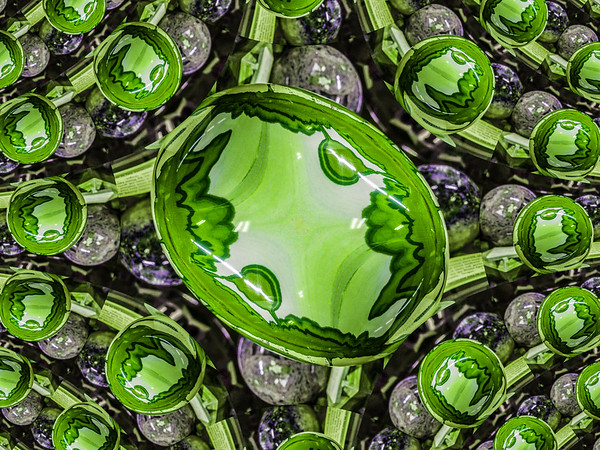

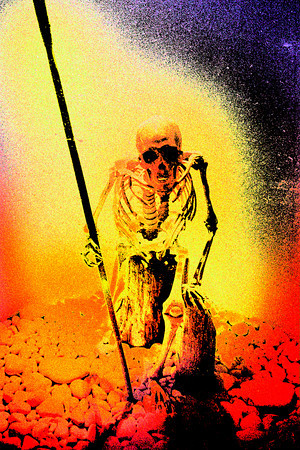

In [7]:
display(image1)
display(image2)

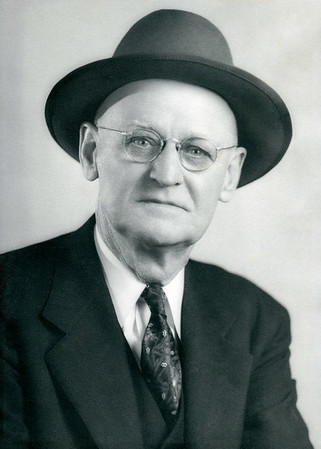

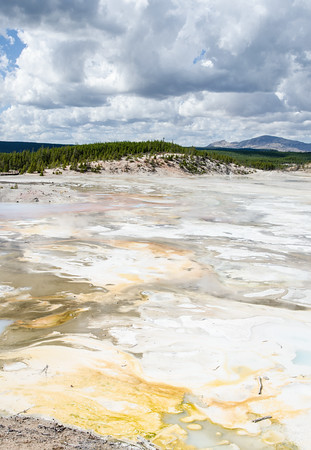

In [8]:
display(image3)
display(image4)

### Define Display Utilities

Before running through the dominant color calculations let's define a few display utilities.

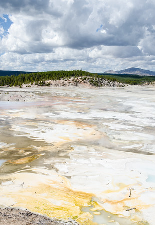

In [9]:
def resize_image(image, factor):
    """Resize PIL image maintaining aspect ratio."""
    imcopy = image.copy()
    width, height = imcopy.size
    width = int(factor * width)
    height = int(factor * height) 
    return imcopy.resize((width, height))

imnew = resize_image(image4, 0.5)
display(imnew)

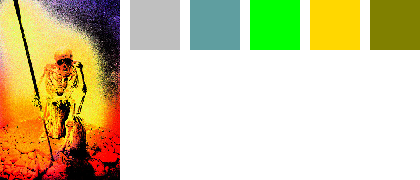

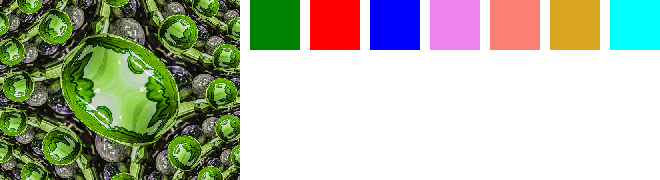

In [10]:
def show_image_name_colors(image, color_names, *, factor=0.4, patch_size=(50,50), spacing=10):
    """Display resized image with adjacent named color patches."""
    imnew = resize_image(image, factor)
    # NIMP check that image is larger than patch size
    height = imnew.size[1]
    width = imnew.size[0] + (spacing + patch_size[0]) * len(color_names)
    background = Image.new('RGBA', (width,height), (255, 255, 255, 255))
    background.paste(imnew, (0,0))
    for i, name in enumerate(color_names):
        patch = Image.new("RGB", patch_size, name)
        background.paste(patch, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), 0))
    display(background)

show_image_name_colors(image2, ["silver","cadetblue","lime","gold","olive"])
show_image_name_colors(image1, ["green","red","blue","violet","salmon","goldenrod","cyan"])    

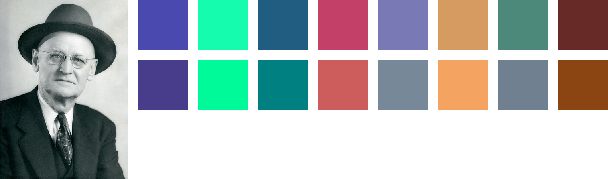

[38.0, 29.765752132274432, 48.11444689487763, 31.591137997862628, 32.71085446759225, 32.28002478313795, 43.139309220245984, 48.11444689487763]
mean:         37.9644965489
variance:     50.0720017917
standard dev: 7.07615727579


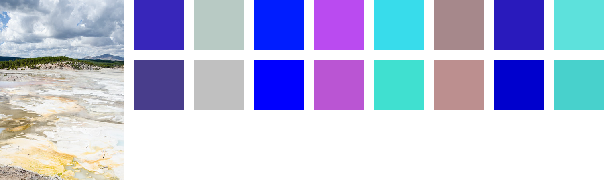

[55.018178813915675, 13.416407864998739, 29.0, 30.675723300355934, 28.442925306655784, 23.430749027719962, 51.43928459844674, 30.870698080866262]
mean:         32.7867458741
variance:     168.279294986
standard dev: 12.9722509606


In [11]:
def show_image_colors(image, colors, *, factor=0.4, patch_size=(50,50), spacing=10):
    """
    Display resized image with adjacent color patches.
    The top patch row shows raw colors and the second
    shows nearest named colors.
    """
    imnew = resize_image(image, factor)
    # NIMP check that image is 2 * larger than patch size.
    height = imnew.size[1]
    width = imnew.size[0] + (spacing + patch_size[0]) * len(colors)
    background = Image.new('RGBA', (width,height), (255, 255, 255, 255))
    background.paste(imnew, (0,0))
    rgb_distance = []
    for i, color in enumerate(colors):
        r, g, b = color
        patch1 = Image.new("RGB", patch_size, (int(r),int(g),int(b)))
        background.paste(patch1, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), 0))
        name , rgb_metric = get_color_name((r,g,b))[1:]
        rgb_distance.append(rgb_metric)
        patch2 = Image.new("RGB", patch_size, name)
        background.paste(patch2, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), spacing + patch_size[1]))
    display(background)
    print(rgb_distance)
    print("mean:         %s" % np.mean(rgb_distance))
    print("variance:     %s" % np.var(rgb_distance))
    print("standard dev: %s" % np.std(rgb_distance))

rcolors0 = []
rcolors1 = []
for a,b in 8 * [(0,255)]:
    rgb0 = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    rgb1 = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    rcolors0.append(rgb0)
    rcolors1.append(rgb1)
    
show_image_colors(image3, rcolors0)
show_image_colors(image4, rcolors1)    

### First Dominant Color Calculation

After making some minor code edits it's possible to 
run this [algorithm from Stack Overflow](https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image).

In [12]:
def array_from_image(image, *, factor=0.4):
    image = resize_image(image, factor)
    ar = np.asarray(image)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
    return ar

def calc1_colors(ar, *, num_clusters=8, factor=0.4):
    colors, dist = scipy.cluster.vq.kmeans(ar, num_clusters)
    return colors

def calc1_peak(ar, colors):
    vecs, dist = scipy.cluster.vq.vq(ar, colors)        # assign codes
    counts, bins = scipy.histogram(vecs, len(colors))   # count occurrences
    index_max = scipy.argmax(counts)                    # find most frequent
    peak = colors[index_max]
    return peak

def calc1_colors_peak(image, *, num_clusters=8, factor=0.4):
    ar = array_from_image(image, factor=factor)
    colors = calc1_colors(ar, num_clusters=num_clusters)
    peak = calc1_peak(ar, colors)
    return (colors, peak)
    
NUM_CLUSTERS = 8

calc1_colors1, calc1_peak1 = calc1_colors_peak(image1, num_clusters=NUM_CLUSTERS) 
calc1_colors2, calc1_peak2 = calc1_colors_peak(image2, num_clusters=NUM_CLUSTERS) 
calc1_colors3, calc1_peak3 = calc1_colors_peak(image3, num_clusters=NUM_CLUSTERS) 
calc1_colors4, calc1_peak4 = calc1_colors_peak(image4, num_clusters=NUM_CLUSTERS) 

print('peak1', calc1_peak1)
print('peak2', calc1_peak2)
print('peak3', calc1_peak3)
print('peak4', calc1_peak4)

peak1 [ 18.29273562  24.01566298  10.66675668]
peak2 [ 241.62207822  224.37236751  131.87734321]
peak3 [ 224.87512176  226.90005845  223.25073057]
peak4 [ 240.50926407  238.96987013  234.4638961 ]


### Display Cluster and Named Colors for the First Calculation

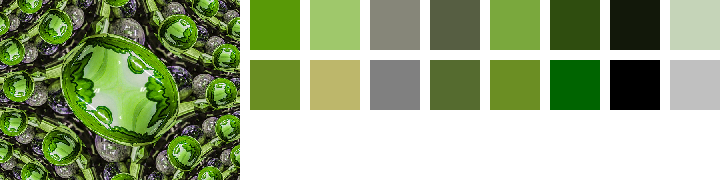

[34.18648708833937, 34.12588439157962, 11.204249799323609, 22.883916448480292, 41.145262463161245, 54.85518015222336, 32.01805651160962, 22.197870492925396]
mean:         31.5771134185
variance:     153.189100712
standard dev: 12.3769584597


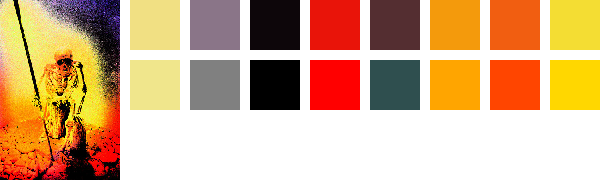

[10.013937217598986, 16.649603778728004, 18.27988401521161, 31.411676986720263, 57.00214881304554, 19.947993177197358, 33.71109633753977, 52.976004392023285]
mean:         29.9990430898
variance:     261.107202954
standard dev: 16.1588119289


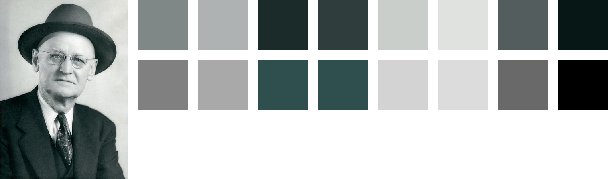

[10.335471929634062, 15.252572111391258, 54.32511876562006, 25.461227471161664, 12.798764284360711, 9.05234046830287, 26.35765849626902, 33.20609244153233]
mean:         23.348655746
variance:     202.600217486
standard dev: 14.2337703187


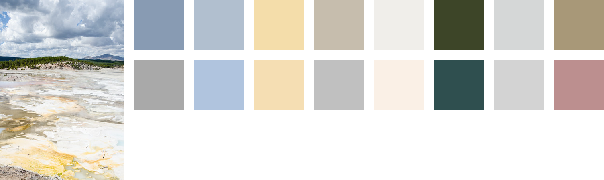

[37.036712701799615, 15.723659443941397, 8.75697173553705, 19.654471357236552, 10.53857696668172, 42.01062408465054, 6.293190338248676, 31.8249868041553]
mean:         21.479899179
variance:     164.904246578
standard dev: 12.8415048409


In [13]:
show_image_colors(image1, calc1_colors1)   
show_image_colors(image2, calc1_colors2)
show_image_colors(image3, calc1_colors3)
show_image_colors(image4, calc1_colors4)

### Second Dominant Color Calculation

This algorithm, due to [Charlies Leifer](https://charlesleifer.com/blog/using-python-and-k-means-to-find-the-dominant-colors-in-images/), also computes dominant colors.

In [14]:
Point = namedtuple('Point', ('coords', 'n', 'ct'))
Cluster = namedtuple('Cluster', ('points', 'center', 'n'))

def get_points(img):
    points = []
    w, h = img.size
    for count, color in img.getcolors(w * h):
        points.append(Point(color, 3, count))
    return points

rtoh = lambda rgb: '#%s' % ''.join(('%02x' % p for p in rgb))

def calc2_colors(image, *, num_clusters=8, factor=0.4):
    img = resize_image(image, factor)
    w, h = img.size

    points = get_points(img)
    clusters = kmeans(points, num_clusters, 1)
    rgbs = [map(int, c.center.coords) for c in clusters]
    return map(rtoh, rgbs)

def euclidean(p1, p2):
    return sqrt(sum([
        (p1.coords[i] - p2.coords[i]) ** 2 for i in range(p1.n)
    ]))

def calculate_center(points, n):
    vals = [0.0 for i in range(n)]
    plen = 0
    for p in points:
        plen += p.ct
        for i in range(n):
            vals[i] += (p.coords[i] * p.ct)
    return Point([(v / plen) for v in vals], n, 1)

def kmeans(points, k, min_diff):
    clusters = [Cluster([p], p, p.n) for p in random.sample(points, k)]

    while 1:
        plists = [[] for i in range(k)]

        for p in points:
            smallest_distance = float('Inf')
            for i in range(k):
                distance = euclidean(p, clusters[i].center)
                if distance < smallest_distance:
                    smallest_distance = distance
                    idx = i
            plists[idx].append(p)

        diff = 0
        for i in range(k):
            old = clusters[i]
            center = calculate_center(plists[i], old.n)
            new = Cluster(plists[i], center, old.n)
            clusters[i] = new
            diff = max(diff, euclidean(old.center, new.center))

        if diff < min_diff:
            break

    return clusters

In [15]:
dmap1 = calc2_colors(image1, num_clusters=8)
dmap2 = calc2_colors(image2, num_clusters=8)
dmap3 = calc2_colors(image3, num_clusters=8)
dmap4 = calc2_colors(image4, num_clusters=8)
colors1 = [webcolors.hex_to_rgb(i) for i in list(dmap1)]
colors2 = [webcolors.hex_to_rgb(i) for i in list(dmap2)]
colors3 = [webcolors.hex_to_rgb(i) for i in list(dmap3)]
colors4 = [webcolors.hex_to_rgb(i) for i in list(dmap4)]

### Display Cluster and Named Colors for the Second Calculation

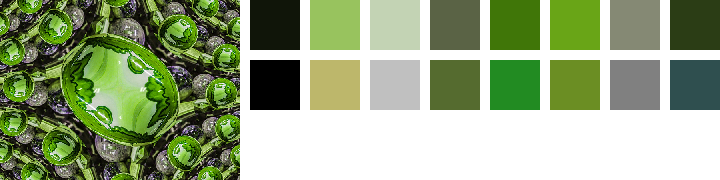

[27.892651361962706, 41.012193308819754, 22.67156809750927, 23.93741840717165, 44.91102314577124, 26.019223662515376, 15.811388300841896, 60.860496218811754]
mean:         32.8894953129
variance:     192.656098061
standard dev: 13.8800611692


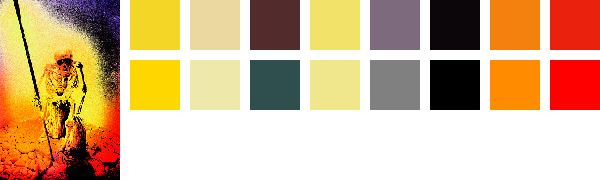

[39.57271787481876, 19.949937343260004, 61.204574992397426, 34.36568055487916, 22.293496809607955, 16.73320053068151, 20.83266665599966, 40.91454509095757]
mean:         31.9833524816
variance:     199.065164039
standard dev: 14.1090454688


In [16]:
show_image_colors(image1, colors1)
show_image_colors(image2, colors2)

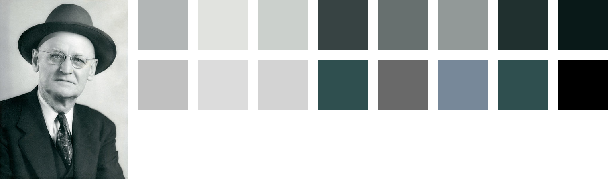

[19.8997487421324, 9.1104335791443, 11.045361017187261, 18.76166303929372, 9.433981132056603, 31.921779399024736, 47.01063709417264, 35.805027579936315]
mean:         22.8735789479
variance:     170.924386116
standard dev: 13.0738053418


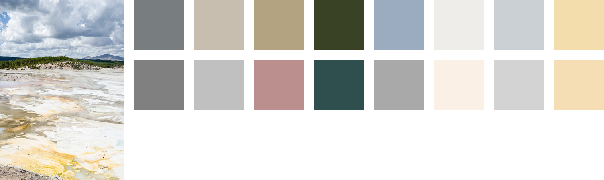

[8.246211251235321, 18.49324200890693, 26.570660511172846, 45.088801270381985, 27.94637722496424, 12.727922061357855, 8.774964387392123, 7.3484692283495345]
mean:         19.399580993
variance:     151.531257297
standard dev: 12.3098033005


In [17]:
show_image_colors(image3, colors3)
show_image_colors(image4, colors4)

## Third Dominant Color Calculation

This algorithm, due to [Srijan Anand](https://github.com/srijannnd/Dominant-Color-Extraction-Dominance-and-Recoloring), is another variation on *kmeans*. The original notebook code required
some changes as `cv2` is not currently available for Python 3.6 Win64 Anaconda systems. It can be replaced
with `PIL`.

In [18]:
km = KMeans(n_clusters=8)
print(km)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [19]:
def calc3_colors(image, num_clusters=8):
    km = KMeans(n_clusters=num_clusters)
    image = resize_image(image, factor=0.4)
    ar = np.asarray(image)
    shape = ar.shape
    pixels = ar.reshape((-1, 3))
    km.fit(pixels)
    colors = np.asarray(km.cluster_centers_, dtype='uint8')
    # improved rounding - has little effect
    #colors = np.asarray(np.around(km.cluster_centers_,0), dtype='uint8')
    return (colors, pixels, km)

def calc3_percentage(pixels, km):
    percentage = np.asarray(np.unique(km.labels_, return_counts = True)[1], dtype='float32')
    percentage = percentage/pixels.shape[0]
    return percentage

In [20]:
def calc3_dominance_patch(colors, pixels, km):
    percentage = calc3_percentage(pixels, km)
    dom = [[percentage[ix], colors[ix]] for ix in range(km.n_clusters)]
    dominance = sorted(dom, key=lambda x:x[0], reverse=True)
    plt.figure(0)
    plt.axis("off")
    patch = np.zeros((50, 500, 3))
    start = 0
    names = []
    for cx in range(km.n_clusters):
        da = dominance[cx][0] * patch.shape[1]
        width = int(da)
        end = start + width
        cb = dominance[cx][1]
        # nearest named color
        nc = get_color_name(cb)[1]  
        names.append(nc)
        r, g, b = webcolors.name_to_rgb(nc)
        patch[:, start:end, :] = 255 - np.asarray([r,g,b], dtype=np.uint8)
        start = end
    plt.imshow(patch)
    plt.show()
    print(names)

colors1 , pixels1 , km1 = calc3_colors(image1)
colors2 , pixels2 , km2 = calc3_colors(image2)
colors3 , pixels3 , km3 = calc3_colors(image3)
colors4 , pixels4 , km4 = calc3_colors(image4)

### Display Cluster and Named Colors for the Third Calculation

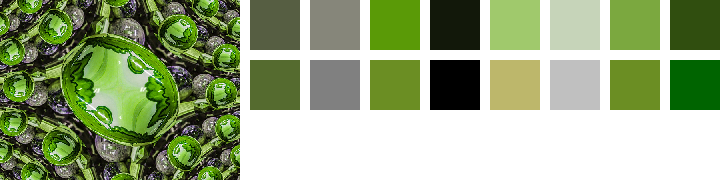

[23.043437243605826, 10.392304845413264, 34.88552708502482, 31.622776601683793, 34.14674215792775, 22.02271554554524, 41.42463035441596, 54.89080068645383]
mean:         31.553616815
variance:     158.869265892
standard dev: 12.6043352023


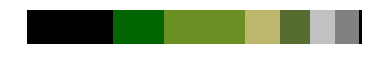

['black', 'darkgreen', 'olivedrab', 'olivedrab', 'darkkhaki', 'darkolivegreen', 'silver', 'grey']


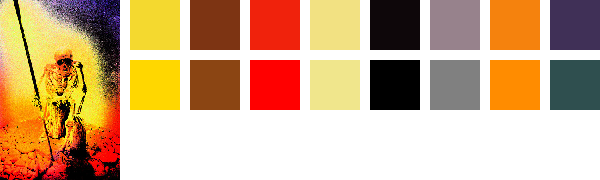

[48.31148931672465, 22.02271554554524, 39.05124837953327, 11.357816691600547, 18.57417562100671, 26.019223662515376, 19.209372712298546, 36.24913792078372]
mean:         27.5993974813
variance:     135.523258672
standard dev: 11.6414457295


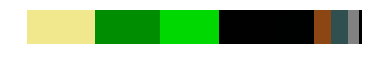

['khaki', 'darkorange', 'gold', 'black', 'red', 'saddlebrown', 'darkslategrey', 'grey']


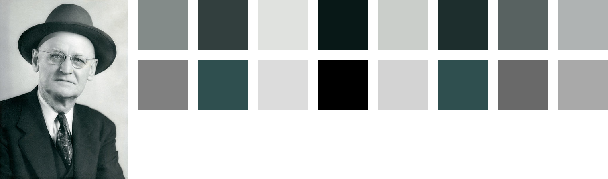

[14.52583904633395, 23.53720459187964, 7.810249675906654, 34.19064199455752, 13.674794331177344, 50.68530358989675, 20.049937655763422, 15.362291495737216]
mean:         22.4795327977
variance:     168.295605199
standard dev: 12.9728796032


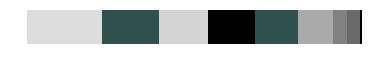

['gainsboro', 'darkslategrey', 'lightgrey', 'black', 'darkslategrey', 'darkgrey', 'grey', 'dimgrey']


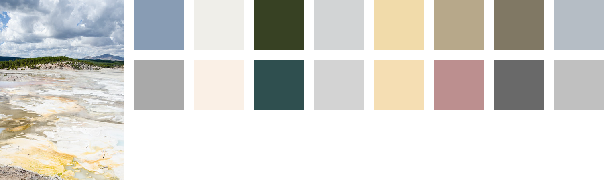

[37.134889255254286, 11.575836902790225, 46.861498055439924, 2.449489742783178, 10.295630140987, 25.98076211353316, 27.910571473905726, 12.449899597988733]
mean:         21.8323221603
variance:     202.099709087
standard dev: 14.2161777242


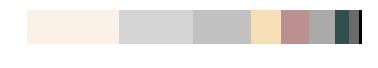

['linen', 'lightgrey', 'silver', 'wheat', 'rosybrown', 'darkgrey', 'darkslategrey', 'dimgrey']


In [21]:
show_image_colors(image1, colors1)
calc3_dominance_patch(colors1, pixels1, km1)
show_image_colors(image2, colors2)
calc3_dominance_patch(colors2, pixels2, km2)
show_image_colors(image3, colors3)
calc3_dominance_patch(colors3, pixels3, km3)
show_image_colors(image4, colors4)
calc3_dominance_patch(colors4, pixels4, km4)

### Named Color Selection Tests

All these *kmeans* algorithms produce similar results. The first and third calculations are faster
than the second which is to be expected from library routines. When the raw colors are mapped
to named colors the shifts can lead to poor choices. To refine the choice this heuristic is employed.

1. Look at the list of named colors. If a named color appears more than once pick the most
   frequently occuring name. For the third calculation "olivedrab" appears twice. I think
   this is a better choice than the dominant most frequent raw color that is mapped to "black."
   
2. If there are no repeated named colors toss out greatest color distance, compute the remaining
   mean and standard deviation. Sort the colors by frequency then pick the first color
   with a distance that is less than or equal one standard deviation from the mean.
   
The following function implements this method.

In [ ]:
def dominant_color_key(names_freqs_dists):
        """
        Return a single dominant color key.
        """
        names , frequencies , distances = names_freqs_dists
       
        if len(names) > len(list(set(names))):
            # most frequent repeated named color
            key = self.most_common(names)
        else:
            # distances less greatest outlier
            dist_sample = sorted(distances, reverse=True)[1:]
            threshold = np.mean(dist_sample) + np.std(dist_sample)
            
            # default color choice
            key = names[0]
            
            # return first color from sorted names that is no more
            # than one standard deviation from the sample mean. If
            # no such choice is made retain the default selection.
            for name, distance in zip(names, distances): 
                if distance <= threshold:
                    key = name
                    break
                
        return self.dominant_prefix + key.lower().strip()

### Frequencies of Color Keys

I applied this method to all the sample images in my `c:/SmugMirror` directories and analyzed
the color assignments. The following table summarizes the results.

        +-----+-----------------------+---------+-----------+-----------+-------+
        |count|color key              |frequency|percent    |cummulative|reverse|
        +-----+-----------------------+---------+-----------+-----------+-------+
        | 1   |`0_darkslategrey       |702      |  16.521534|16.521534  |4249   |
        | 2   |`0_black               |549      |  12.920687|29.442222  |3547   |
        | 3   |`0_dimgrey             |286      |  6.7309955|36.173217  |2998   |
        | 4   |`0_darkgrey            |263      |  6.1896917|42.362909  |2712   |
        | 5   |`0_grey                |250      |  5.8837373|48.246646  |2449   |
        | 6   |`0_darkolivegreen      |244      |  5.7425277|53.989174  |2199   |
        | 7   |`0_silver              |223      |  5.2482937|59.237468  |1955   |
        | 8   |`0_gainsboro           |142      |  3.3419628| 62.57943  |1732   |
        | 9   |`0_lightsteelblue      |139      |   3.271358|65.850788  |1590   |
        |10   |`0_steelblue           |128      |  3.0124735|68.863262  |1451   |
        |11   |`0_lightgrey           |113      |  2.6594493|71.522711  |1323   |
        |12   |`0_rosybrown           |108      |  2.5417745|74.064486  |1210   |
        |13   |`0_lavender            | 94      |  2.2122852|76.276771  |1102   |
        |14   |`0_tan                 | 83      |  1.9534008|78.230172  |1008   |
        |15   |`0_whitesmoke          | 49      |  1.1532125|79.383384  | 925   |
        |16   |`0_lightslategrey      | 48      |  1.1296776|80.513062  | 876   |
        |17   |`0_cornflowerblue      | 48      |  1.1296776|81.642739  | 828   |
        |18   |`0_sienna              | 47      |  1.1061426|82.748882  | 780   |
        |19   |`0_midnightblue        | 39      | 0.91786303|83.666745  | 733   |
        |20   |`0_peru                | 39      | 0.91786303|84.584608  | 694   |
        |21   |`0_lightblue           | 38      | 0.89432808|85.478936  | 655   |
        |22   |`0_linen               | 37      | 0.87079313|86.349729  | 617   |
        |23   |`0_olivedrab           | 32      | 0.75311838|87.102848  | 580   |
        |24   |`0_white               | 30      | 0.70604848|87.808896  | 548   |
        |25   |`0_burlywood           | 30      | 0.70604848|88.514945  | 518   |
        |26   |`0_skyblue             | 30      | 0.70604848|89.220993  | 488   |
        |27   |`0_darkkhaki           | 28      | 0.65897858|89.879972  | 458   |
        |28   |`0_saddlebrown         | 27      | 0.63544363|90.515415  | 430   |
        |29   |`0_wheat               | 27      | 0.63544363|91.150859  | 403   |
        |30   |`0_snow                | 24      | 0.56483879|91.715698  | 376   |
        |31   |`0_darkslateblue       | 21      | 0.49423394|92.209932  | 352   |
        |32   |`0_slategrey           | 20      | 0.47069899|92.680631  | 331   |
        |33   |`0_antiquewhite        | 17      | 0.40009414|93.080725  | 311   |
        |34   |`0_cadetblue           | 16      | 0.37655919|93.457284  | 294   |
        |35   |`0_powderblue          | 15      | 0.35302424|93.810308  | 278   |
        |36   |`0_indianred           | 14      | 0.32948929|94.139798  | 263   |
        |37   |`0_firebrick           | 12      | 0.28241939|94.422217  | 249   |
        |38   |`0_darkseagreen        | 11      | 0.25888444|94.681101  | 237   |
        |39   |`0_maroon              | 10      | 0.23534949|94.916451  | 226   |
        |40   |`0_lightskyblue        | 10      | 0.23534949|  95.1518  | 216   |
        |41   |`0_ghostwhite          |  9      | 0.21181454|95.363615  | 206   |
        |42   |`0_bisque              |  9      | 0.21181454| 95.57543  | 197   |
        |43   |`0_royalblue           |  8      |  0.1882796|95.763709  | 188   |
        |44   |`0_goldenrod           |  8      |  0.1882796|95.951989  | 180   |
        |45   |`0_chocolate           |  8      |  0.1882796|96.140268  | 172   |
        |46   |`0_sandybrown          |  8      |  0.1882796|96.328548  | 164   |
        |47   |`0_oldlace             |  7      | 0.16474465|96.493293  | 156   |
        |48   |`0_teal                |  7      | 0.16474465|96.658037  | 149   |
        |49   |`0_deepskyblue         |  7      | 0.16474465|96.822782  | 142   |
        |50   |`0_beige               |  6      |  0.1412097|96.963992  | 135   |
        |51   |`0_palegoldenrod       |  6      |  0.1412097|97.105201  | 129   |
        |52   |`0_brown               |  6      |  0.1412097|97.246411  | 123   |
        |53   |`0_thistle             |  6      |  0.1412097|97.387621  | 117   |
        |54   |`0_orangered           |  6      |  0.1412097| 97.52883  | 111   |
        |55   |`0_crimson             |  5      | 0.11767475|97.646505  | 105   |
        |56   |`0_olive               |  5      | 0.11767475| 97.76418  | 100   |
        |57   |`0_darksalmon          |  5      | 0.11767475|97.881855  |  95   |
        |58   |`0_seagreen            |  5      | 0.11767475|97.999529  |  90   |
        |59   |`0_aliceblue           |  5      | 0.11767475|98.117204  |  85   |
        |60   |`0_paleturquoise       |  4      |0.094139798|98.211344  |  80   |
        |61   |`0_khaki               |  4      |0.094139798|98.305484  |  76   |
        |62   |`0_lightyellow         |  3      |0.070604848|98.376088  |  72   |
        |63   |`0_lightgoldenrodyellow|  3      |0.070604848|98.446693  |  69   |
        |64   |`0_darkred             |  3      |0.070604848|98.517298  |  66   |
        |65   |`0_floralwhite         |  3      |0.070604848|98.587903  |  63   |
        |66   |`0_navajowhite         |  3      |0.070604848|98.658508  |  60   |
        |67   |`0_darkgoldenrod       |  3      |0.070604848|98.729113  |  57   |
        |68   |`0_tomato              |  3      |0.070604848|98.799718  |  54   |
        |69   |`0_deeppink            |  3      |0.070604848|98.870322  |  51   |
        |70   |`0_darkcyan            |  3      |0.070604848|98.940927  |  48   |
        |71   |`0_palevioletred       |  3      |0.070604848|99.011532  |  45   |
        |72   |`0_mintcream           |  3      |0.070604848|99.082137  |  42   |
        |73   |`0_mediumblue          |  3      |0.070604848|99.152742  |  39   |
        |74   |`0_pink                |  2      |0.047069899|99.199812  |  36   |
        |75   |`0_gold                |  2      |0.047069899|99.246882  |  34   |
        |76   |`0_darkblue            |  2      |0.047069899|99.293952  |  32   |
        |77   |`0_orchid              |  2      |0.047069899|99.341021  |  30   |
        |78   |`0_lightpink           |  2      |0.047069899|99.388091  |  28   |
        |79   |`0_seashell            |  2      |0.047069899|99.435161  |  26   |
        |80   |`0_mediumseagreen      |  2      |0.047069899|99.482231  |  24   |
        |81   |`0_dodgerblue          |  2      |0.047069899|99.529301  |  22   |
        |82   |`0_lightcyan           |  2      |0.047069899|99.576371  |  20   |
        |83   |`0_darkturquoise       |  2      |0.047069899|99.623441  |  18   |
        |84   |`0_red                 |  1      |0.023534949|99.646976  |  16   |
        |85   |`0_yellow              |  1      |0.023534949|99.670511  |  15   |
        |86   |`0_cornsilk            |  1      |0.023534949|99.694046  |  14   |
        |87   |`0_mistyrose           |  1      |0.023534949|99.717581  |  13   |
        |88   |`0_mediumaquamarine    |  1      |0.023534949|99.741116  |  12   |
        |89   |`0_plum                |  1      |0.023534949|99.764651  |  11   |
        |90   |`0_darkmagenta         |  1      |0.023534949|99.788185  |  10   |
        |91   |`0_hotpink             |  1      |0.023534949| 99.81172  |   9   |
        |92   |`0_peachpuff           |  1      |0.023534949|99.835255  |   8   |
        |93   |`0_blanchedalmond      |  1      |0.023534949| 99.85879  |   7   |
        |94   |`0_lavenderblush       |  1      |0.023534949|99.882325  |   6   |
        |95   |`0_blue                |  1      |0.023534949| 99.90586  |   5   |
        |96   |`0_mediumpurple        |  1      |0.023534949|99.929395  |   4   |
        |97   |`0_navy                |  1      |0.023534949| 99.95293  |   3   |
        |98   |`0_slateblue           |  1      |0.023534949|99.976465  |   2   |
        |99   |`0_orange              |  1      |0.023534949|      100  |   1   |
        +-----+-----------------------+---------+-----------+-----------+-------+
        
A number of things are apparent from this test.

1. Only 99 of 147 possible colors appear: about 67%.

2. The first six colors are assigned to over 50% of all images.

3. The first color is assigned more often than the last 79 colors.

4. *kmeans* dominant colors are not particularily meaningful for photographs.

### An Revised Color Selection

To reduce the frequency of the first six selections the following revised function
looks at the frequencies of these colors and only accepts them if they exceed a certain threshold.